## Sign Language Detection using Resnet 50

In [ ]:
pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


### Import Libraries 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import sklearn as sklearn
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

from keras.models import Model
from keras.preprocessing import image
%matplotlib inline
import os
import cv2
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.python.keras.layers import Input, Dense, Flatten, Lambda, Dropout

In [ ]:
data_dir = '/content/drive/MyDrive/DLProject/asl/'

In [ ]:
x = np.load(data_dir + 'train_imgs_64.npy')
y = np.load(data_dir + 'train_labels_64.npy')
# x = x.astype('float32') / 255.0
y = tf.keras.utils.to_categorical(y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1, shuffle=True)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(52200, 64, 64, 3) (52200, 29)
(17400, 64, 64, 3) (17400, 29)


###  Image Data Augmentation

We have implemented Image Augmentation using ImageDataGenerator - an augmented image generator API in Keras. It generates batches of image data with real-time data augmentation. For practical applications we have applied rotation, height/weight shift, zoom, flip and brightness high/low to our training dataset.

In [ ]:
classes = 29
batch_size = 32
epochs = 50
learning_rate = 1e-4

In [ ]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  
      
datagen.fit(x_train)

Metrics have been removed from Keras core. We need to calculate them manually.

In [ ]:
from tensorflow.keras import backend as K
def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

### Implement the Deep Learning Model - Resnet50

ResNet-50 is a convolutional neural network that is 50 layers deep. We can load a pretrained version of the network trained on more than a million images from the ImageNet database.

In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(64,64,3),
                   pooling='max', classes=classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
# Fully Connected Layer
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.6))
resnet_model.add(Dense(classes, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 512)              0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 29)               14877     
 pper)                                                  

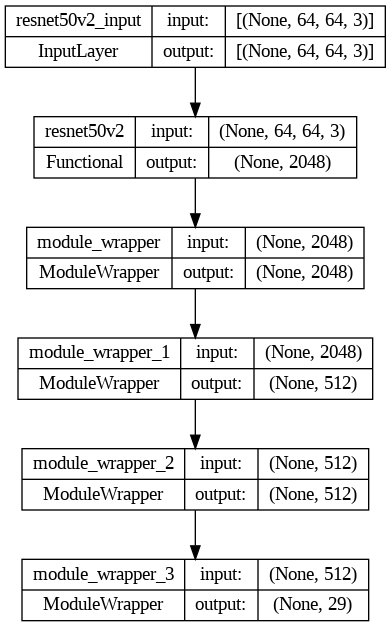

In [ ]:
tf.keras.utils.plot_model(resnet_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best.h5",
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
# With data aug
# history = resnet_model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                          #  epochs=epochs, validation_data=val_dataset)

# Without data aug
history = resnet_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/50
1632/1632 [==============================] - 43s 19ms/step - loss: 1.8081 - accuracy: 0.5157 - val_loss: 0.6105 - val_accuracy: 0.8578
Epoch 2/50
1632/1632 [==============================] - 31s 19ms/step - loss: 0.6931 - accuracy: 0.7935 - val_loss: 0.3175 - val_accuracy: 0.9275
Epoch 3/50
1632/1632 [==============================] - 31s 19ms/step - loss: 0.4254 - accuracy: 0.8730 - val_loss: 0.1986 - val_accuracy: 0.9555
Epoch 4/50
1632/1632 [==============================] - 30s 19ms/step - loss: 0.2980 - accuracy: 0.9116 - val_loss: 0.1424 - val_accuracy: 0.9676
Epoch 5/50
1632/1632 [==============================] - 30s 19ms/step - loss: 0.2194 - accuracy: 0.9348 - val_loss: 0.1048 - val_accuracy: 0.9771
Epoch 6/50
1632/1632 [==============================] - 30s 19ms/step - loss: 0.1725 - accuracy: 0.9504 - val_loss: 0.0824 - val_accuracy: 0.9814
Epoch 7/50
1632/1632 [==============================] - 30s 18ms/step - loss: 0.1361 - accuracy: 0.9615 - val_loss: 0.0635 -

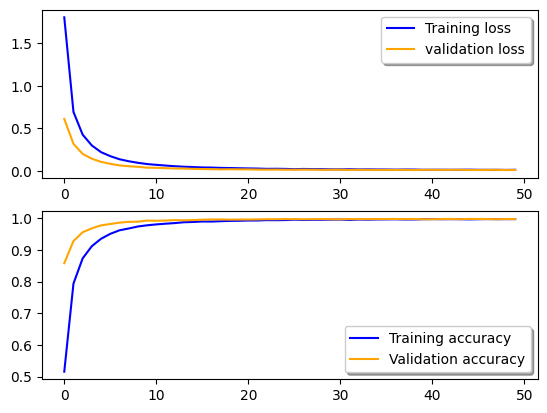

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='orange', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)


ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='orange',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Learning Curves - Graphs

544/544 [==============================] - 8s 12ms/step


<Axes: >

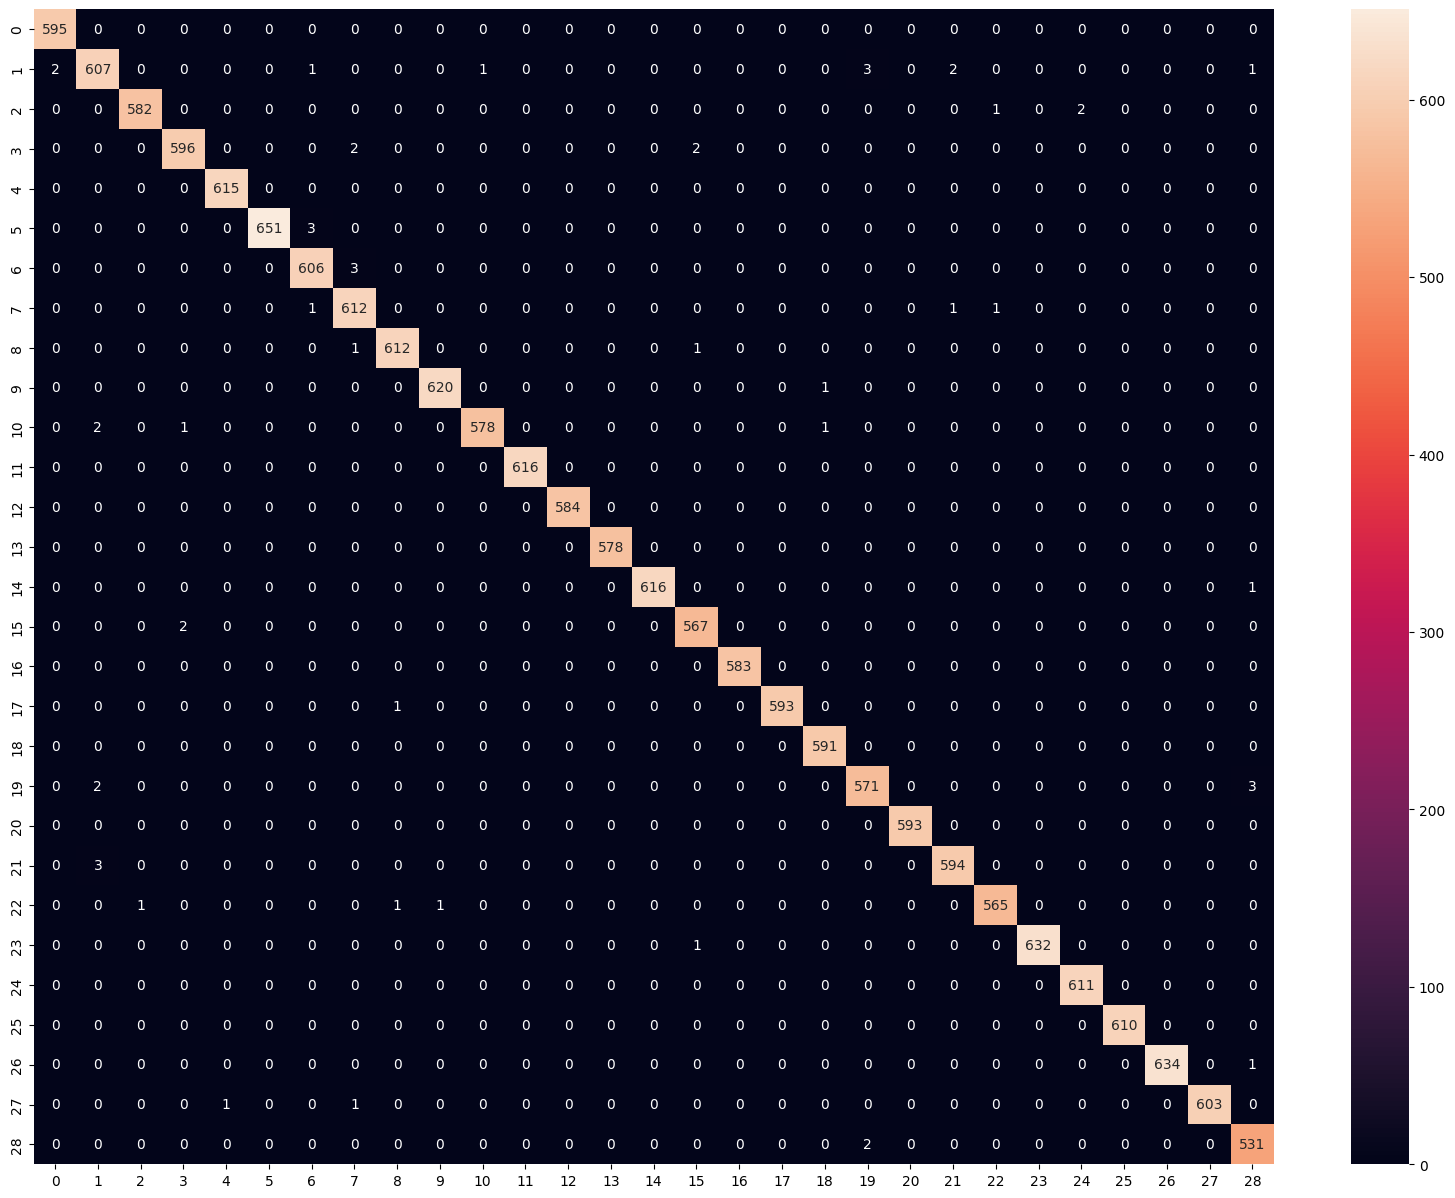

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# # Get the true labels by iterating over the validation generator
# val_labels = []
# for i in range(len(val_generator)):
#     _, labels = val_generator[i]
#     val_labels.extend(np.argmax(labels, axis=1))

# Get the predicted labels using the trained model
Y_pred = resnet_model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
targets = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cf_mat = confusion_matrix(targets, y_pred)

plt.figure(figsize=(20,15))

# plot the confusion matrix
sns.heatmap(cf_mat, annot=True, fmt="d")
# cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]

In [ ]:
np.save(data_dir + 'resnet50_cm_5.npy', cf_mat)
np.save(data_dir + 'resnet50_targets_5.npy', targets)
np.save(data_dir + 'resnet50_preds_5.npy', y_pred)

In [ ]:
print("Accuracy of the model is - " , resnet_model.evaluate(x_test,y_test)[1]*100 , "%")

544/544 [==============================] - 8s 14ms/step - loss: 0.0111 - accuracy: 0.9969
Accuracy of the model is -  99.68965649604797 %


In [ ]:
print(classification_report(targets, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       595
           1       0.99      0.98      0.99       617
           2       1.00      0.99      1.00       585
           3       0.99      0.99      0.99       600
           4       1.00      1.00      1.00       615
           5       1.00      1.00      1.00       654
           6       0.99      1.00      0.99       609
           7       0.99      1.00      0.99       615
           8       1.00      1.00      1.00       614
           9       1.00      1.00      1.00       621
          10       1.00      0.99      1.00       582
          11       1.00      1.00      1.00       616
          12       1.00      1.00      1.00       584
          13       1.00      1.00      1.00       578
          14       1.00      1.00      1.00       617
          15       0.99      1.00      0.99       569
          16       1.00      1.00      1.00       583
          17       1.00    

### Predict Images 

In [ ]:
#Creating a dictionary to map each of the indexes to the corresponding number or letter
from keras.preprocessing import image
dict = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",
        11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",
        24:"Y",25:"Z"}


#Predicting images

img = image.load_img("sign_B2.jpg", target_size=(180, 180))
x = image.img_to_array(img)
plt.imshow(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = resnet_model.predict(image, batch_size=64)
label = [np.argmax(i) for i in classes]
pred_class=[dict[x] for x in label]
pred_class

### Evaluating the Model 

_Plotting the Confusion Matrix_


In [ ]:
Y_pred = resnet_model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
cf_mat = confusion_matrix(val_generator.classes, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 6))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

_Printing the Classification Report_

In [ ]:
labels = val_generator.classes

_Evalutation Metrics on Test Set_

In [ ]:
loss, accuracy, f1_score, precision, recall = resnet_model.evaluate(val_ds, verbose=0)

In [ ]:
print(f"Test Loss: ", round(loss*100, 3), '%')
print(f"Test Accuracy: ", round(accuracy*100, 3), '%')
print(f"Test Precision: ", round(precision*100, 3), '%')
print(f"Test Recall: ",round(recall*100, 3), '%')
print(f"Test F1 Score: ",round(f1_score*100, 3), '%')